# imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import joblib
warnings.filterwarnings('ignore')

# settings

In [97]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Titanic Survival Prediction Project

In [98]:
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Warning: Data files not found. Download train.csv and test.csv from Kaggle.")
    np.random.seed(42)
    n_samples = 891
    train_df = pd.DataFrame({
        'PassengerId': range(1, n_samples+1),
        'Survived': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
        'Pclass': np.random.choice([1, 2, 3], n_samples, p=[0.3, 0.3, 0.4]),
        'Name': [f'Passenger_{i}' for i in range(n_samples)],
        'Sex': np.random.choice(['male', 'female'], n_samples),
        'Age': np.random.normal(30, 15, n_samples),
        'SibSp': np.random.poisson(0.5, n_samples),
        'Parch': np.random.poisson(0.4, n_samples),
        'Ticket': [f'TICKET_{i}' for i in range(n_samples)],
        'Fare': np.random.exponential(30, n_samples),
        'Cabin': [f'C{i}' if np.random.random() > 0.7 else np.nan for i in range(n_samples)],
        'Embarked': np.random.choice(['C', 'Q', 'S'], n_samples, p=[0.2, 0.1, 0.7])
    })
    print("Demo dataset created.")


Data loaded successfully!


# Dataset Information

In [99]:
print(f"\nDataset Information:")
print(f"Rows: {train_df.shape[0]}")
print(f"Columns: {train_df.shape[1]}")
print(f"Target variable: Survived (0: Did not survive, 1: Survived)")


Dataset Information:
Rows: 891
Columns: 12
Target variable: Survived (0: Did not survive, 1: Survived)


In [100]:
print("\nFirst 5 rows:")
print(train_df.head())



First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

# Missing values

In [101]:
print("\nData Types and Missing Values:")
info_df = pd.DataFrame({
    'Column': train_df.columns,
    'Data Type': train_df.dtypes.values,
    'Missing Count': train_df.isnull().sum().values,
    'Missing %': (train_df.isnull().sum() / len(train_df) * 100).round(2).values
})
print(info_df)




Data Types and Missing Values:
         Column Data Type  Missing Count  Missing %
0   PassengerId     int64              0       0.00
1      Survived     int64              0       0.00
2        Pclass     int64              0       0.00
3          Name    object              0       0.00
4           Sex    object              0       0.00
5           Age   float64            177      19.87
6         SibSp     int64              0       0.00
7         Parch     int64              0       0.00
8        Ticket    object              0       0.00
9          Fare   float64              0       0.00
10        Cabin    object            687      77.10
11     Embarked    object              2       0.22


In [102]:
print("\nStatistical Summary for Numerical Variables:")
print(train_df.describe())



Statistical Summary for Numerical Variables:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [103]:
survival_counts = train_df['Survived'].value_counts()
survival_rate = train_df['Survived'].mean()

print(f"\nTarget Variable Analysis:")
print(f"Survived: {survival_counts[1]} passengers ({survival_counts[1]/len(train_df)*100:.1f}%)")
print(f"Did not survive: {survival_counts[0]} passengers ({survival_counts[0]/len(train_df)*100:.1f}%)")
print(f"Overall survival rate: {survival_rate*100:.1f}%")



Target Variable Analysis:
Survived: 342 passengers (38.4%)
Did not survive: 549 passengers (61.6%)
Overall survival rate: 38.4%


# Visilation

Text(0.5, 0.98, 'Titanic Dataset - Exploratory Data Analysis')

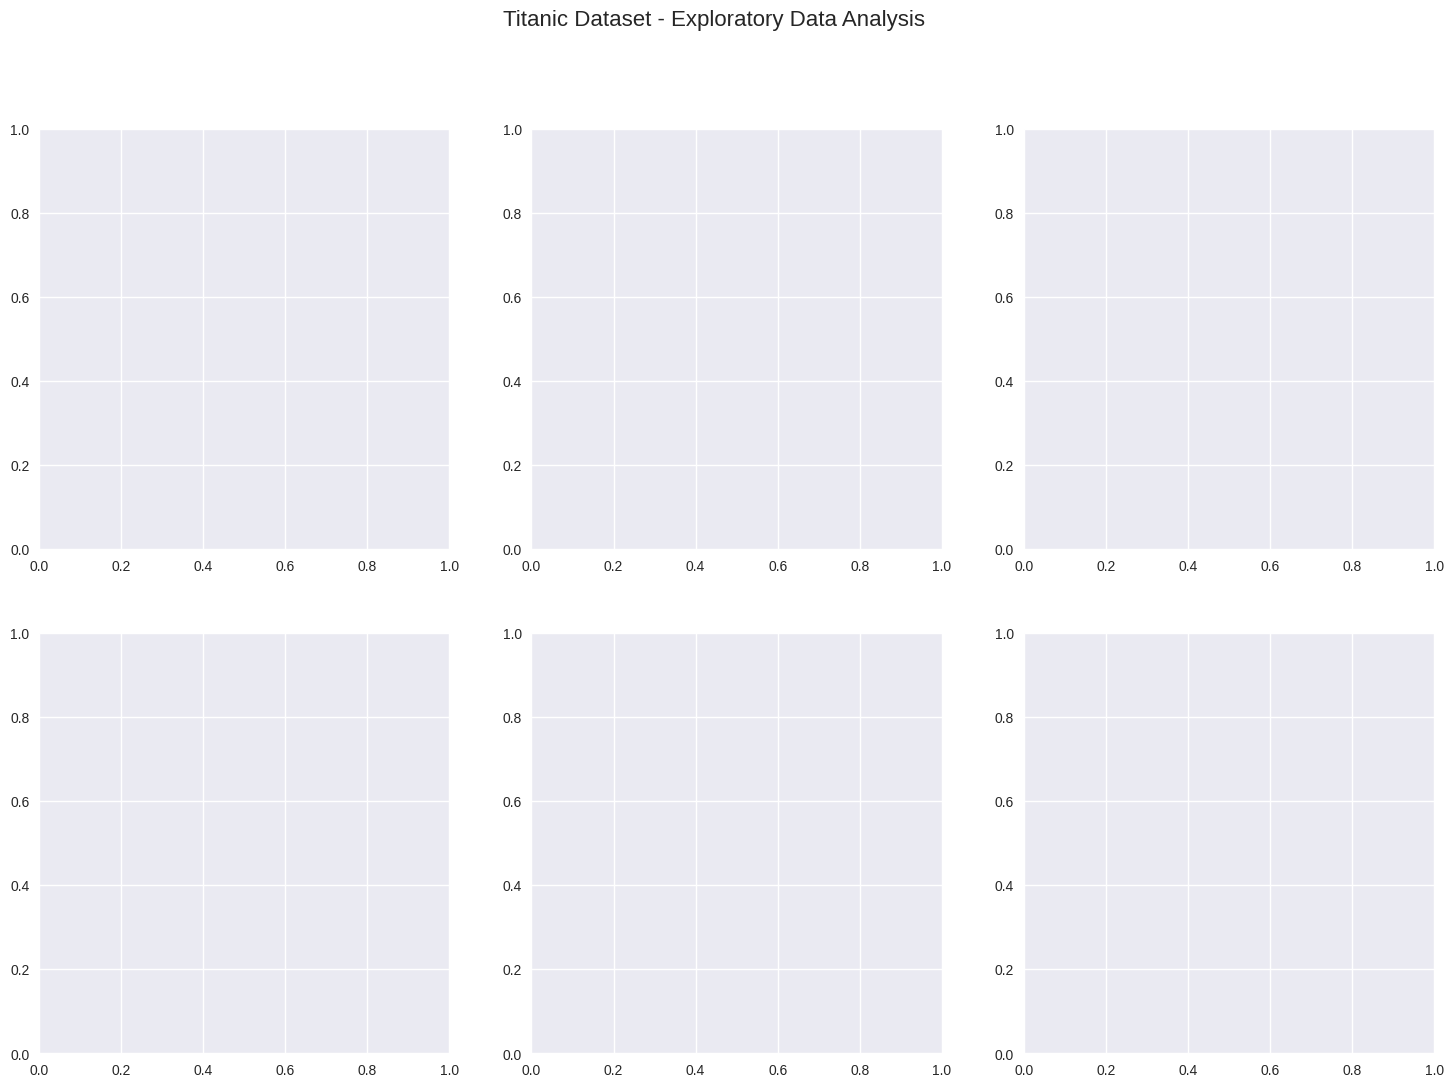

In [104]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16)

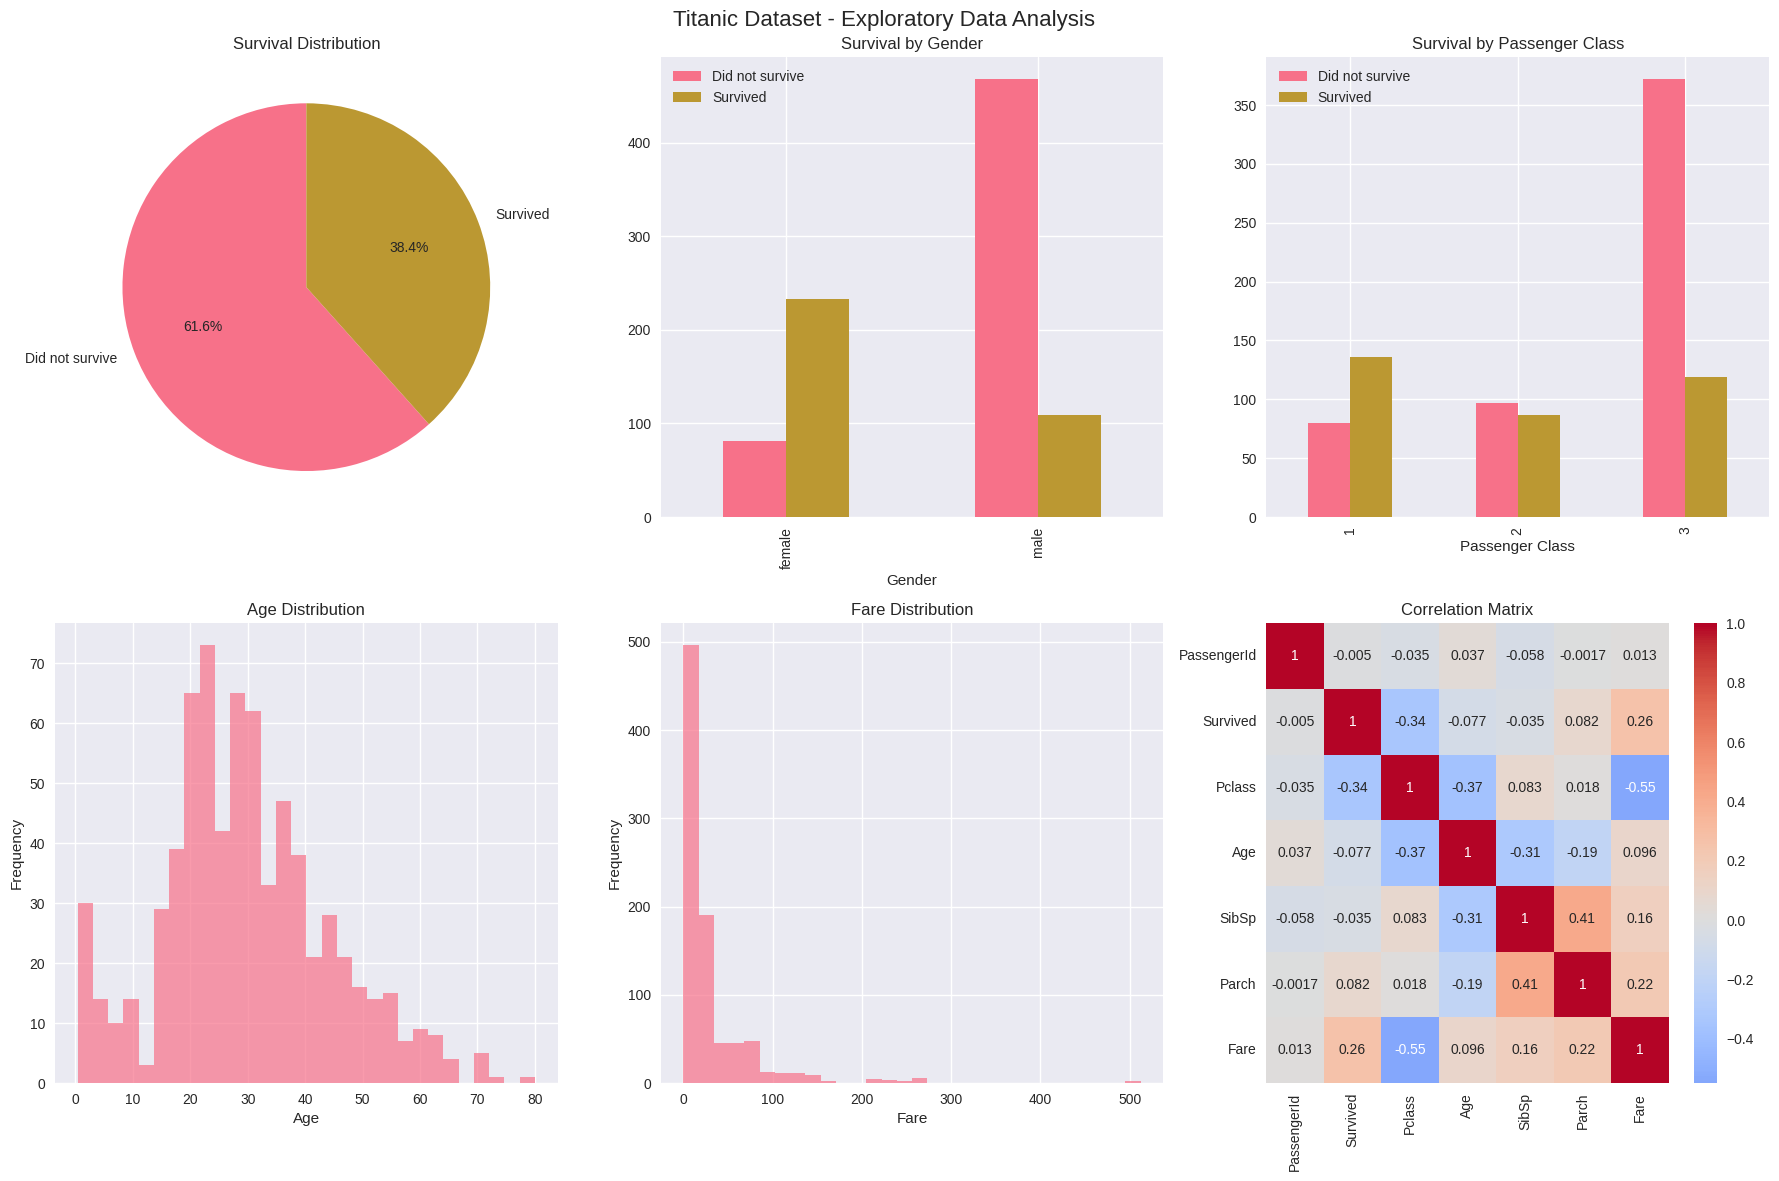

In [105]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16)

axes[0, 0].pie(survival_counts.values, labels=['Did not survive', 'Survived'],
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Survival Distribution')

survival_by_sex = pd.crosstab(train_df['Sex'], train_df['Survived'])
survival_by_sex.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Survival by Gender')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].legend(['Did not survive', 'Survived'])

survival_by_class = pd.crosstab(train_df['Pclass'], train_df['Survived'])
survival_by_class.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Survival by Passenger Class')
axes[0, 2].set_xlabel('Passenger Class')
axes[0, 2].legend(['Did not survive', 'Survived'])

axes[1, 0].hist(train_df['Age'].dropna(), bins=30, alpha=0.7)
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(train_df['Fare'].dropna(), bins=30, alpha=0.7)
axes[1, 1].set_title('Fare Distribution')
axes[1, 1].set_xlabel('Fare')
axes[1, 1].set_ylabel('Frequency')

numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Variables Analysis

In [106]:
print("\nCategorical Variables Analysis:")
categorical_cols = ['Sex', 'Embarked', 'Pclass']
for col in categorical_cols:
    if col in train_df.columns:
        print(f"\n{col} Distribution and Survival Rates:")
        crosstab = pd.crosstab(train_df[col], train_df['Survived'], margins=True)
        crosstab['Survival_Rate_%'] = (crosstab[1] / (crosstab[0] + crosstab[1]) * 100).round(1)
        print(crosstab)


Categorical Variables Analysis:

Sex Distribution and Survival Rates:
Survived    0    1  All  Survival_Rate_%
Sex                                     
female     81  233  314             74.2
male      468  109  577             18.9
All       549  342  891             38.4

Embarked Distribution and Survival Rates:
Survived    0    1  All  Survival_Rate_%
Embarked                                
C          75   93  168             55.4
Q          47   30   77             39.0
S         427  217  644             33.7
All       549  340  889             38.2

Pclass Distribution and Survival Rates:
Survived    0    1  All  Survival_Rate_%
Pclass                                  
1          80  136  216             63.0
2          97   87  184             47.3
3         372  119  491             24.2
All       549  342  891             38.4


#Preproccesing

# Missing Value Handling

In [107]:
df = train_df.copy()

if 'Age' in df.columns:
    age_median = df['Age'].median()
    df['Age'].fillna(age_median, inplace=True)
    print(f"   Age missing values filled with median ({age_median:.1f})")

if 'Embarked' in df.columns:
    most_common_embarked = df['Embarked'].mode()[0]
    df['Embarked'].fillna(most_common_embarked, inplace=True)
    print(f"   Embarked missing values filled with mode ('{most_common_embarked}')")

if 'Fare' in df.columns:
    fare_median = df['Fare'].median()
    df['Fare'].fillna(fare_median, inplace=True)
    print(f"   Fare missing values filled with median ({fare_median:.2f})")




   Age missing values filled with median (28.0)
   Embarked missing values filled with mode ('S')
   Fare missing values filled with median (14.45)


# Feature Engineering

In [108]:

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
print("   FamilySize feature created (siblings + parents + self)")

df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
print("   IsAlone feature created (binary indicator)")

if 'Name' in df.columns:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                      'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    print("   Title feature extracted from passenger names")

df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                       labels=['Child', 'Teenager', 'Adult', 'Senior', 'Elderly'])
print("   AgeGroup feature created with 5 categories")

df['FareGroup'] = pd.cut(df['Fare'], bins=[0, 7.91, 14.45, 31, 100000],
                        labels=['Low', 'Medium', 'High', 'VeryHigh'])
print("   FareGroup feature created based on quartiles")


   FamilySize feature created (siblings + parents + self)
   IsAlone feature created (binary indicator)
   Title feature extracted from passenger names
   AgeGroup feature created with 5 categories
   FareGroup feature created based on quartiles


#  Categorical Variable Encoding

In [109]:
le = LabelEncoder()
categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']

for feature in categorical_features:
    if feature in df.columns:
        df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))
        print(f"   {feature} encoded using LabelEncoder")

   Sex encoded using LabelEncoder
   Embarked encoded using LabelEncoder
   Title encoded using LabelEncoder
   AgeGroup encoded using LabelEncoder
   FareGroup encoded using LabelEncoder


# Feature Selection

In [110]:
features = ['Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch', 'Fare',
           'Embarked_encoded', 'FamilySize', 'IsAlone', 'Title_encoded']

available_features = [f for f in features if f in df.columns]
print(f"   Selected features: {available_features}")

X = df[available_features]
y = df['Survived']

print(f"   Feature matrix shape: {X.shape}")
print(f"   Target vector shape: {y.shape}")


   Selected features: ['Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_encoded', 'FamilySize', 'IsAlone', 'Title_encoded']
   Feature matrix shape: (891, 10)
   Target vector shape: (891,)


# Feature Scaling

In [111]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("   Features standardized using StandardScaler")



   Features standardized using StandardScaler


# Train-Test Split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Training survival rate: {y_train.mean()*100:.1f}%")
print(f"   Test survival rate: {y_test.mean()*100:.1f}%")



   Training set: 712 samples
   Test set: 179 samples
   Training survival rate: 38.3%
   Test survival rate: 38.5%


# Select Best Model

In [113]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Model Comparison

In [114]:
model_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model_results[name] = {
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'CV_Scores': cv_scores
    }
    print(f"{name:20s}: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


Logistic Regression : 0.8020 (+/- 0.0469)
Random Forest       : 0.8063 (+/- 0.0685)
Gradient Boosting   : 0.8203 (+/- 0.0620)
SVM                 : 0.8245 (+/- 0.0240)
KNN                 : 0.8034 (+/- 0.0493)


# Best Model

In [115]:
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['CV_Mean'])
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Cross validation accuracy: {model_results[best_model_name]['CV_Mean']:.4f}")



Best performing model: SVM
Cross validation accuracy: 0.8245


# Training

In [116]:
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"Optimizing hyperparameters for {best_model_name}...")

    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    else:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'min_samples_split': [2, 5, 10]
        }

    grid_search = GridSearchCV(
        best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"Hyperparameter optimization completed!")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    final_model = grid_search.best_estimator_
else:
    final_model = best_model
    final_model.fit(X_train, y_train)

# MODEL EVALUATION

In [117]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1] if hasattr(final_model, 'predict_proba') else None

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)



In [118]:
print("Performance Metrics:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.1f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.1f}%)")
print(f"   F1 Score:  {f1:.4f} ({f1*100:.1f}%)")

Performance Metrics:
   Accuracy:  0.8380 (83.8%)
   Precision: 0.8125 (81.2%)
   Recall:    0.7536 (75.4%)
   F1 Score:  0.7820 (78.2%)


In [119]:
if y_pred_proba is not None:
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"   AUC Score: {auc_score:.4f} ({auc_score*100:.1f}%)")

# Confusion Matrix

[[98 12]
 [17 52]]


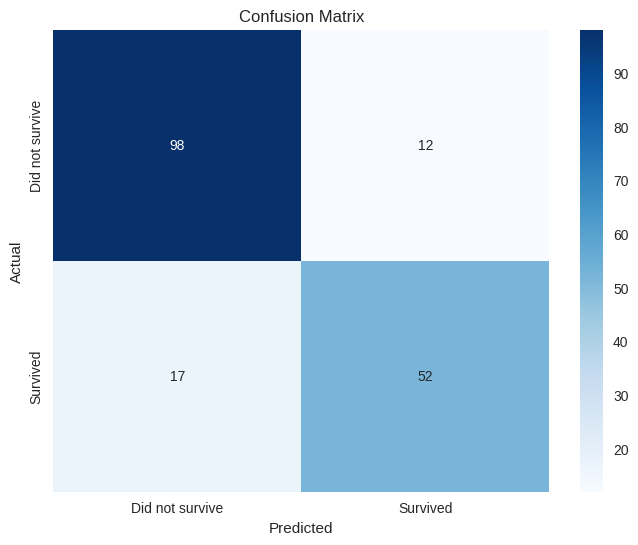

In [120]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did not survive', 'Survived'],
            yticklabels=['Did not survive', 'Survived'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Detailed Classification Report

In [121]:
print(classification_report(y_test, y_pred,
                          target_names=['Did not survive', 'Survived']))


                 precision    recall  f1-score   support

Did not survive       0.85      0.89      0.87       110
       Survived       0.81      0.75      0.78        69

       accuracy                           0.84       179
      macro avg       0.83      0.82      0.83       179
   weighted avg       0.84      0.84      0.84       179



In [122]:
if hasattr(final_model, 'feature_importances_'):
    print("\nFeature Importance Ranking:")
    feature_importance = pd.DataFrame({
        'Feature': available_features,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='Importance', y='Feature')
    plt.title('Feature Importance Ranking')
    plt.xlabel('Importance Score')
    plt.show()



In [123]:
if y_pred_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Analysis')
    plt.legend(loc="lower right")
    plt.show()



# PROJECT SUMMARY

In [124]:
print(f"""
PROJECT SUMMARY:
================

Dataset: Titanic Survival Prediction
   • Total passengers: {len(train_df)}
   • Overall survival rate: {survival_rate*100:.1f}%
   • Features used: {len(available_features)}

Best Model: {best_model_name}
   • Test accuracy: {accuracy*100:.1f}%
   • F1 Score: {f1:.3f}
   • Cross validation score: {model_results[best_model_name]['CV_Mean']:.3f}

Key Findings:
   • Most important factors: Gender, passenger class, age
   • Women had significantly higher survival rates than men
   • First-class passengers had better survival chances
   • Family size influenced survival probability

Real-world Applications:
   • Emergency response planning and risk assessment
   • Safety protocol development for maritime travel
   • Passenger profiling for enhanced safety measures

Future Improvements:
   • Advanced feature engineering techniques
   • Ensemble methods combining multiple models
   • Deep learning approaches
   • Extended hyperparameter optimization
""")



PROJECT SUMMARY:

Dataset: Titanic Survival Prediction
   • Total passengers: 891
   • Overall survival rate: 38.4%
   • Features used: 10

Best Model: SVM
   • Test accuracy: 83.8%
   • F1 Score: 0.782
   • Cross validation score: 0.824

Key Findings:
   • Most important factors: Gender, passenger class, age
   • Women had significantly higher survival rates than men
   • First-class passengers had better survival chances
   • Family size influenced survival probability

Real-world Applications:
   • Emergency response planning and risk assessment
   • Safety protocol development for maritime travel
   • Passenger profiling for enhanced safety measures

Future Improvements:
   • Advanced feature engineering techniques
   • Ensemble methods combining multiple models
   • Deep learning approaches
   • Extended hyperparameter optimization



In [125]:
print("Project completed successfully!")
print("Remember to add these results to your GitHub README.md file.")
print("Make your Kaggle notebook public and add the link to README.")


Project completed successfully!
Remember to add these results to your GitHub README.md file.
Make your Kaggle notebook public and add the link to README.


# Save Model

In [126]:
model_filename = f'titanic_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved as '{model_filename}'")

Model saved as 'titanic_model_svm.pkl'
